In [1]:
import json
from tqdm.notebook import tqdm
import psycopg2
import psycopg2.extras
from pprint import pprint
import datetime
from numpy import interp
from matplotlib import pyplot
import pandas as pd
import pandas.io.sql as sqlio
from pandas.plotting import scatter_matrix
from matplotlib.pyplot import figure
import copy
import matplotlib.pyplot as plt
import collections

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import export_graphviz

In [3]:
def resultsAsDictArray(results, colnames):
    return_array = []
    for result in tqdm(results):
        d = {}
        for col in colnames:
            d[col] = result[colnames.index(col)]
        return_array.append(d)
    return return_array

In [4]:
conn = psycopg2.connect(user='postgres', database="postgres", password='password', host='localhost', port='5432')
cursor = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

In [5]:
cursor.execute('SELECT * FROM music')
results = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
musics = resultsAsDictArray(results, colnames)

  0%|          | 0/697510 [00:00<?, ?it/s]

In [6]:
cursor.execute('SELECT * FROM music_artist')
results = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
musics_artists_raw = resultsAsDictArray(results, colnames)

  0%|          | 0/1127195 [00:00<?, ?it/s]

In [7]:
musics_artists = {}
for music_artist in musics_artists_raw:
    music_id = music_artist['music_id']
    if music_id not in musics_artists:
        musics_artists[music_id] = []
    musics_artists[music_id].append(music_artist['artist_id'])

In [8]:
cursor.execute("""
SELECT * 
FROM artist a 
INNER JOIN genre_artist ga ON a.artist_id = ga.artist_id
INNER JOIN genre g ON g.genre_id = ga.genre_id
INNER JOIN genre_category gc ON gc.genre_id = g.genre_id
INNER JOIN category c ON c.category_id = gc.category_id
""")
results = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
artists_raw = resultsAsDictArray(results, colnames)

  0%|          | 0/12574 [00:00<?, ?it/s]

In [9]:
artists_multiple = {}
for artist in artists_raw:
    artist_id = artist['artist_id']
    if artist_id not in artists_multiple:
        artists_multiple[artist_id] = []
    artists_multiple[artist_id].append(artist)
#     pprint(artist)
#     break

In [10]:
artists = {}
for artist in tqdm(artists_multiple):
    for i in artists_multiple[artist]:
        if i['artist_id'] not in artists:
            artists[i['artist_id']] = copy.deepcopy(i)
            artists[i['artist_id']]['genres'] = set()
            artists[i['artist_id']]['categories'] = set()
            artists[i['artist_id']].pop('category_id', None)
            artists[i['artist_id']].pop('category', None)
            artists[i['artist_id']].pop('genre_artist_id', None)
            artists[i['artist_id']].pop('genre_category_id', None)
            artists[i['artist_id']].pop('genre_id', None)
            artists[i['artist_id']].pop('genre', None)
        artists[i['artist_id']]['genres'].add(i['genre'])
        artists[i['artist_id']]['categories'].add(i['category'])
#     pprint(artists)
#     break

  0%|          | 0/3380 [00:00<?, ?it/s]

In [11]:
cursor.execute('SELECT * FROM category')
results = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
categories = resultsAsDictArray(results, colnames)

  0%|          | 0/21 [00:00<?, ?it/s]

In [12]:
cursor.execute('SELECT * FROM genre')
results = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
genres = resultsAsDictArray(results, colnames)

  0%|          | 0/1583 [00:00<?, ?it/s]

In [30]:
for music in musics:
    music_id = music['music_id']
    for category in categories:
        music[category['category']] = 0
    list_artist = []
    for music_artist in musics_artists.get(music_id, []):
        artist = artists.get(music_artist, '')
        if artist == '':
            continue
        for category in list(artist['categories']):
            music[category] = 1
        music['genres'] = ', '.join(list(artist['genres']))
        list_artist.append(artist['name'])
    music['artists'] = ', '.join(list_artist)
#     pprint(music)
#     break

### Via Word2Vec

In [16]:
import nltk
import urllib
import bs4 as bs
import re
import numpy as np
from gensim.models import Word2Vec

In [31]:
genres_raw_words = set()
artists_raw_words = set()
for music in musics:
    text = music.get('genres', '').replace(',', '')
    if text != '':
        genres_raw_words.add(text)
        
    text = music.get('artists', '').replace(',', '').lower()
    text = re.sub(r'\W+', ' ', text)
    if text != '':
        artists_raw_words.add(text)

In [32]:
sentences_genres = [nltk.word_tokenize(sentence) for sentence in genres_raw_words]
model_genres = Word2Vec(sentences_genres, min_count=1)

sentences_artists = [nltk.word_tokenize(sentence) for sentence in artists_raw_words]
model_artists = Word2Vec(sentences_artists, min_count=1)

In [33]:
# similar = model_genres.wv.most_similar('indie')
# similar

In [34]:
similar = model_artists.wv.most_similar('sia')
similar

[('bruno', 0.9938116669654846),
 ('smith', 0.9936599731445312),
 ('emicida', 0.9934771656990051),
 ('diplo', 0.9933702349662781),
 ('mc', 0.9933419227600098),
 ('jorge', 0.9933387041091919),
 ('max', 0.9930333495140076),
 ('r3hab', 0.9929155707359314),
 ('santana', 0.9928524494171143),
 ('eric', 0.9928420186042786)]

In [37]:
np.mean(np.mean([model_artists.wv[token] for token in nltk.word_tokenize('sia')], axis=0))

-0.002232366

In [200]:
for music in tqdm(musics):
    text = music.get('genres', '').replace(',', '')
    if text != '':
        music['genres_emb'] = np.mean(np.mean([model_genres.wv[token] for token in nltk.word_tokenize(text)], axis=0))
        
    text = music.get('artists', '').replace(',', '').lower()
    text = re.sub(r'\W+', ' ', text)
    if text != '':
        music['artists_emb'] = np.mean(np.mean([model_artists.wv[token] for token in nltk.word_tokenize(text)], axis=0))

  0%|          | 0/697510 [00:00<?, ?it/s]

In [201]:
pprint(music)

{'Blues': 0,
 'Classical': 0,
 'Country': 0,
 'Edm': 0,
 'Folk': 0,
 'Funk': 0,
 'Hip hop': 1,
 'Indie': 0,
 'Instrumental': 0,
 'Jazz': 0,
 'Lo-fi': 0,
 'Metal': 0,
 'Nacional': 0,
 'Pop': 1,
 'Punk': 0,
 'R&b': 0,
 'Rap': 1,
 'Reggae': 0,
 'Rock': 0,
 'Sertanejo': 0,
 'Soundtrack': 0,
 'acousticness': 0.162,
 'artists': 'Mike Posner, Big Sean',
 'artists_emb': 0.0009453584,
 'danceability': 0.653,
 'duration_ms': 203346.0,
 'energy': 0.661,
 'genres': 'rap, hip hop, southern hip hop, detroit hip hop, trap, pop rap',
 'genres_emb': 0.012812643,
 'instrumentalness': 1.46e-06,
 'like_rate': None,
 'liveness': 0.394,
 'loudness': -8.036,
 'mode': 0,
 'music_id': 8039,
 'music_key': 7,
 'music_spotify_uri': 'spotify:track:3wxSjRp3mrsr4vaF1VSH4U',
 'name': 'Buried In Detroit - Lucas Löwe Remix',
 'popularity': 0,
 'speechiness': 0.0371,
 'tempo': 102.962,
 'time_signature': 4.0,
 'valence': 0.65}


# Train Model

In [202]:
df = pd.DataFrame.from_records(musics)

In [376]:
# Eram 697510 rows × 36 columns
df_filtered = df.drop(columns=['name', 'duration_ms', 'mode', 'time_signature', 'genres', 'artists'])
df_filtered = df_filtered[df_filtered['genres_emb'].notna()]
df_filtered = df_filtered[df_filtered['artists_emb'].notna()]

df_filtered.insert(2, 'like_rate_temp', df_filtered['like_rate'])
df_filtered.drop('like_rate', axis=1, inplace=True) 
df_filtered.rename(columns={'like_rate_temp': 'like_rate'}, inplace=True)

df_filtered = df_filtered.reset_index()
df_filtered = df_filtered.drop(columns=['index'])



df_filtered

,music_id,music_spotify_uri,like_rate,popularity,danceability,energy,music_key,loudness,speechiness,acousticness,...,Funk,Soundtrack,Punk,Country,Classical,Instrumental,Sertanejo,Lo-fi,genres_emb,artists_emb
0,8040,spotify:track:0awxPw2WkYJVzcSKWvJZAh,NaN,45.0,0.631,0.534000,2.0,-6.783,0.0848,0.5050,...,0,0,0,0,0,0,0,0,0.014622,-0.001097
1,8041,spotify:track:4ToSbnK7fD5vE9R5sgWPsy,NaN,0.0,0.536,0.762000,8.0,-6.749,0.0427,0.2700,...,0,0,0,0,0,0,0,0,0.011400,-0.001744
2,8042,spotify:track:5GW2n1h3BNYnpU7lK23iKv,NaN,0.0,0.695,0.705000,7.0,-5.493,0.0243,0.3140,...,0,0,0,0,0,0,0,0,0.011400,-0.001744
3,8043,spotify:track:3M0pROlXyH0bzh9CNJhDOJ,NaN,0.0,0.656,0.572000,4.0,-8.162,0.0319,0.6530,...,0,0,0,0,0,0,0,0,0.011400,-0.001744
4,8044,spotify:track:1uGAMOMKqPPYxAllZ1PV4s,NaN,0.0,0.696,0.417000,9.0,-9.624,0.0270,0.8260,...,0,0,0,0,0,0,0,0,0.011400,-0.001744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532621,8035,spotify:track:3Z9Kaszz1KKOdWhP7Q8fVR,NaN,0.0,0.000,0.000278,5.0,-32.668,0.0000,0.0219,...,0,0,0,0,0,0,0,0,0.016600,-0.002409
532622,8036,spotify:track:20FREPNcSl4TnZEt1GAYSB,NaN,0.0,0.717,0.807000,8.0,-8.348,0.0632,0.0912,...,0,0,0,0,0,0,0,0,0.016600,-0.002409
532623,8037,spotify:track:47uRsTBT1Jb93QSvY5C12O,NaN,0.0,0.670,0.685000,2.0,-5.486,0.0510,0.0625,...,0,0,0,0,0,0,0,0,0.016600,-0.002409
532624,8038,spotify:track:6vzhxMkDnTdRURQzqI1p0L,NaN,0.0,0.814,0.642000,0.0,-6.394,0.0951,0.1320,...,0,0,0,0,0,0,0,0,0.016600,-0.002409


In [431]:
df_train = df_filtered[df_filtered['like_rate'].notna()]
df_train['like_rate'][df_train['like_rate'] > 0.35] = 1
df_train['like_rate'][df_train['like_rate'] <= 0.35] = 0
df_train

C:\Users\MATHEU~1\AppData\Local\Temp/ipykernel_8684/710602685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['like_rate'][df_train['like_rate'] > 0.35] = 1
c:\dev\miniconda3\lib\site-packages\pandas\core\generic.py:8861: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\MATHEU~1\AppData\Local\Temp/ipykernel_8684/710602685.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train

,music_id,music_spotify_uri,like_rate,popularity,danceability,energy,music_key,loudness,speechiness,acousticness,...,Funk,Soundtrack,Punk,Country,Classical,Instrumental,Sertanejo,Lo-fi,genres_emb,artists_emb
525611,6114,spotify:track:0Mh4id8WvrTFOB9RiVitrB,0.0,0.0,0.758,0.500,1.0,-6.810,0.4370,0.364000,...,0,0,0,0,0,0,0,0,0.012000,-0.000080
525612,4790,spotify:track:4JAbD641MOEYu8bP81rtIG,0.0,0.0,0.548,0.879,11.0,-4.120,0.0478,0.019100,...,0,0,0,0,0,0,0,0,0.015219,-0.001444
525613,273,spotify:track:6u7jPi22kF8CTQ3rb9DHE7,1.0,7.0,0.878,0.619,6.0,-5.560,0.1020,0.053300,...,0,0,0,1,0,0,0,0,0.015006,-0.000421
525614,5761,spotify:track:45sziCSqS4BWSQWUlLRpyf,0.0,55.0,0.439,0.908,4.0,-4.080,0.0644,0.019600,...,0,0,0,0,0,0,0,0,0.013844,0.000686
525615,7662,spotify:track:3lwp8aybnEo8OaO0hzQD0C,0.0,24.0,0.204,0.337,2.0,-12.595,0.0363,0.827000,...,0,0,0,0,1,0,0,0,0.007530,0.001817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532451,19,spotify:track:7pYFPMeK0TnaTGdS6qOtEr,0.0,59.0,0.372,0.919,11.0,-1.680,0.3000,0.098700,...,0,0,0,0,0,0,0,0,0.015497,-0.000654
532452,2,spotify:track:5jjZikDrEd0by1o7V3fO4y,1.0,73.0,0.804,0.323,0.0,-11.127,0.3050,0.308000,...,0,0,0,0,0,0,0,0,0.013614,-0.000869
532453,9,spotify:track:54KFQB6N4pn926IUUYZGzK,1.0,72.0,0.264,0.122,9.0,-15.399,0.0349,0.885000,...,0,0,0,0,0,0,0,0,0.015142,0.000424
532454,1,spotify:track:1TDk2Jmi4dVZhm2dum3Jim,0.0,66.0,0.452,0.873,9.0,-4.867,0.0613,0.000519,...,0,0,0,0,0,0,0,0,0.013934,0.000167


In [432]:
array = df_train.values
X = array[:,3:]
y = array[:,2]
y = y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [433]:
y

array([0, 0, 1, ..., 1, 0, 0])

In [434]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
dtc.score(X_test, y_test)

0.7434112381899552

In [435]:
dtc = DecisionTreeClassifier(criterion='entropy', max_features=10, random_state=42, max_leaf_nodes=150, max_depth=7, min_samples_split=100)
dtc.fit(X_train, y_train)
dtc.score(X_test, y_test)

0.8125310790651418

In [436]:
bag = BaggingClassifier(dtc, n_estimators=100, max_samples=0.8, random_state=42)
bag.fit(X_train, y_train)
bag.score(X_test, y_test)

0.8160119343610144

## Try

In [437]:
df_try = df_filtered[df_filtered['like_rate'].isna()]
df_try = df_try.reset_index()
df_try = df_try.drop(columns=['index'])

df_try

,music_id,music_spotify_uri,like_rate,popularity,danceability,energy,music_key,loudness,speechiness,acousticness,...,Funk,Soundtrack,Punk,Country,Classical,Instrumental,Sertanejo,Lo-fi,genres_emb,artists_emb
0,8040,spotify:track:0awxPw2WkYJVzcSKWvJZAh,NaN,45.0,0.631,0.534000,2.0,-6.783,0.0848,0.5050,...,0,0,0,0,0,0,0,0,0.014622,-0.001097
1,8041,spotify:track:4ToSbnK7fD5vE9R5sgWPsy,NaN,0.0,0.536,0.762000,8.0,-6.749,0.0427,0.2700,...,0,0,0,0,0,0,0,0,0.011400,-0.001744
2,8042,spotify:track:5GW2n1h3BNYnpU7lK23iKv,NaN,0.0,0.695,0.705000,7.0,-5.493,0.0243,0.3140,...,0,0,0,0,0,0,0,0,0.011400,-0.001744
3,8043,spotify:track:3M0pROlXyH0bzh9CNJhDOJ,NaN,0.0,0.656,0.572000,4.0,-8.162,0.0319,0.6530,...,0,0,0,0,0,0,0,0,0.011400,-0.001744
4,8044,spotify:track:1uGAMOMKqPPYxAllZ1PV4s,NaN,0.0,0.696,0.417000,9.0,-9.624,0.0270,0.8260,...,0,0,0,0,0,0,0,0,0.011400,-0.001744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525918,8035,spotify:track:3Z9Kaszz1KKOdWhP7Q8fVR,NaN,0.0,0.000,0.000278,5.0,-32.668,0.0000,0.0219,...,0,0,0,0,0,0,0,0,0.016600,-0.002409
525919,8036,spotify:track:20FREPNcSl4TnZEt1GAYSB,NaN,0.0,0.717,0.807000,8.0,-8.348,0.0632,0.0912,...,0,0,0,0,0,0,0,0,0.016600,-0.002409
525920,8037,spotify:track:47uRsTBT1Jb93QSvY5C12O,NaN,0.0,0.670,0.685000,2.0,-5.486,0.0510,0.0625,...,0,0,0,0,0,0,0,0,0.016600,-0.002409
525921,8038,spotify:track:6vzhxMkDnTdRURQzqI1p0L,NaN,0.0,0.814,0.642000,0.0,-6.394,0.0951,0.1320,...,0,0,0,0,0,0,0,0,0.016600,-0.002409


In [438]:
array = df_try.values
X = array[:,3:]

In [439]:
music_note = {}
for i in tqdm(range(0, len(X), 1000)):
    max_i = i + 1000
    if max_i >= len(X):
        max_i = len(X) - 2
    predicted = bag.predict(X[i:max_i])
    for index, value in enumerate(predicted):
        music_note[df_try.loc[i + index]['music_spotify_uri']] = value

  0%|          | 0/526 [00:00<?, ?it/s]

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [440]:
music_note_sorted = dict(sorted(music_note.items(), key=lambda item: item[1], reverse=True))

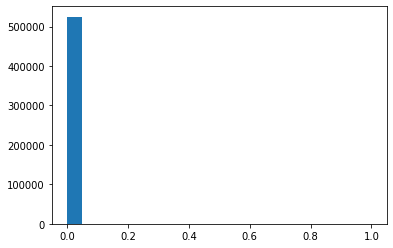

In [441]:
_ = plt.hist(music_note_sorted.values(), bins='auto')

In [442]:
collections.Counter(music_note_sorted.values())

Counter({1: 18, 0: 524982})

In [443]:
music_note_sorted

{'spotify:track:0JKVKU80Hifd9A8lQKi9lc': 1,
 'spotify:track:71nJDkBdbSNBVuw6TC9B5v': 1,
 'spotify:track:5ZUObJNpVt2l9GogUSfALc': 1,
 'spotify:track:14zduMrtXG6iAyoozpQhDA': 1,
 'spotify:track:4PxTFojApbNeeIwiEEx2QX': 1,
 'spotify:track:0s3kijZb80brcA2cdppjBZ': 1,
 'spotify:track:1p9G2aRIbIPQGVXeJgLE4Z': 1,
 'spotify:track:41OAXzXCrDCzRSlD1IBWtP': 1,
 'spotify:track:2wbkovH4lLaiaFOceX1YAr': 1,
 'spotify:track:66rU4Dff6qFAhia56xRs8E': 1,
 'spotify:track:6mEpGxnTjoMdZQjo6UorbK': 1,
 'spotify:track:70kJ2O6JiFg4nTATPw4b0E': 1,
 'spotify:track:6oqlWkAUCqBXjvorIRSm54': 1,
 'spotify:track:1Rzv9hwuNO1H7N947tD1e8': 1,
 'spotify:track:03x5RegHjby0lwfcqQ2GjI': 1,
 'spotify:track:2exUyljlhoH86MlcicuUXd': 1,
 'spotify:track:25TrYuBFlgMIaaQDYZNJoa': 1,
 'spotify:track:4fAWuHhfAqykApaqrR9tfK': 1,
 'spotify:track:0awxPw2WkYJVzcSKWvJZAh': 0,
 'spotify:track:4ToSbnK7fD5vE9R5sgWPsy': 0,
 'spotify:track:5GW2n1h3BNYnpU7lK23iKv': 0,
 'spotify:track:3M0pROlXyH0bzh9CNJhDOJ': 0,
 'spotify:track:1uGAMOMKqPPYxAll